# Estudo de caso 1 - Previsão de Preço de Ações

Features comumente uteis para a previsão do preço das são estes

1. Ativos correlacionados
    * Uma organização depende de e interage com muito fatores externos, incluindo concorrentes, clientes, e economia global, a situação geopolitica, politicas fiscais e monetarias, acesso ao capital e assim por diante.
2. Indicadores tecnicos
    * Media movel, media movel exponencial e momentum
3. Analise fundementalista
4. Relatorio de desempenho
    * Relatorio anuais a trimestrais das empresas podem ser usadas para extrair ou determinar metricas-chave como ROE

5. Noticias

### Carregando dados e pacotes python

In [177]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet
)

from sklearn.tree      import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm       import SVR

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)

from sklearn.neural_network import MLPRegressor

# Para analise de dados e a avaliacao de modelos
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2, f_regression
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# RNA
import tensorflow as tf
import keras

Mais pacotes...

In [178]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import yfinance as yf

Carregando dados

In [179]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

In [180]:
stk_data = yf.download(stk_tickers, start='2015-01-01', auto_adjust=True)
ccy_data = web.DataReader(ccy_tickers, 'fred', start='2015-01-01')
idx_data = web.DataReader(idx_tickers, 'fred', start='2015-01-01')

[*********************100%***********************]  3 of 3 completed


> A target é o retorno semanal da ação da microsoft. Presume-se que o numero de dias uteuis para negociação por semana é cinco, e computamos o retorno usando esse parametro.


> As features são retornos defasados  dos cincos dias das ações, moedas e indices.

In [181]:
period = 5

In [182]:
Y = stk_data.loc[:, ('Close','MSFT')].apply(lambda x: np.log(x)).diff(period).shift(-period)

In [183]:
Y.name = 'MSFT_pred'

In [184]:
Y

Date
2015-01-02    0.009154
2015-01-05    0.005811
2015-01-06    0.015434
2015-01-07   -0.005858
2015-01-08   -0.045350
                ...   
2025-08-04         NaN
2025-08-05         NaN
2025-08-06         NaN
2025-08-07         NaN
2025-08-08         NaN
Name: MSFT_pred, Length: 2666, dtype: float64

In [185]:
X1 = stk_data.loc[:, ('Close',('IBM', 'GOOGL'))].apply(lambda x: np.log(x)).diff(period)

In [186]:
X1.columns = X1.columns.droplevel()

In [187]:
X1

Ticker,IBM,GOOGL
Date,,
2015-01-02,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,NaN,NaN
2015-01-07,NaN,NaN
2015-01-08,NaN,NaN
...,...,...
2025-08-04,-0.043602,0.012693
2025-08-05,-0.045771,-0.005533
2025-08-06,-0.031142,-0.002241


In [188]:
X2 = ccy_data.loc[:, ('DEXJPUS', 'DEXUSUK')].apply(lambda x: np.log(x)).diff(period)
X3 = idx_data.loc[:, ('SP500', 'DJIA', 'VIXCLS')].apply(lambda x: np.log(x)).diff(period)

In [189]:
X4 = pd.concat([
    np.log(stk_data.loc[:, ('Close', 'MSFT')]).diff(i) \
    for i in [period, period*3, period*6, period*12]
], axis=1).dropna()

In [190]:
X4.columns = ['MSFT_DT', 'MSFT_DT3', 'MSFT_DT6', 'MSFT_DT12']

In [191]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [192]:
data = pd.concat([Y, X], axis=1).dropna().iloc[::period,:]

In [193]:
Y = data.loc[:, ~data.columns.isin(X.columns)]
X = data.loc[:, X.columns]

Analise dos dados

In [194]:
data.head(3)

,MSFT_pred,IBM,GOOGL,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_DT3,MSFT_DT6,MSFT_DT12
2015-08-17,-0.120339,-0.002811,0.045644,-0.001768,0.003339,-0.000827,-0.003981,0.062595,-0.000211,0.042523,0.063919,-0.002111
2015-08-24,0.043199,-0.085716,-0.115964,-0.047520,0.008491,-0.104825,-0.100264,1.140724,-0.120339,-0.109503,-0.081996,-0.110570
2015-08-31,0.008466,0.030343,0.046946,0.022518,-0.023671,0.040866,0.040542,-0.359765,0.043199,-0.077351,-0.068651,-0.051887


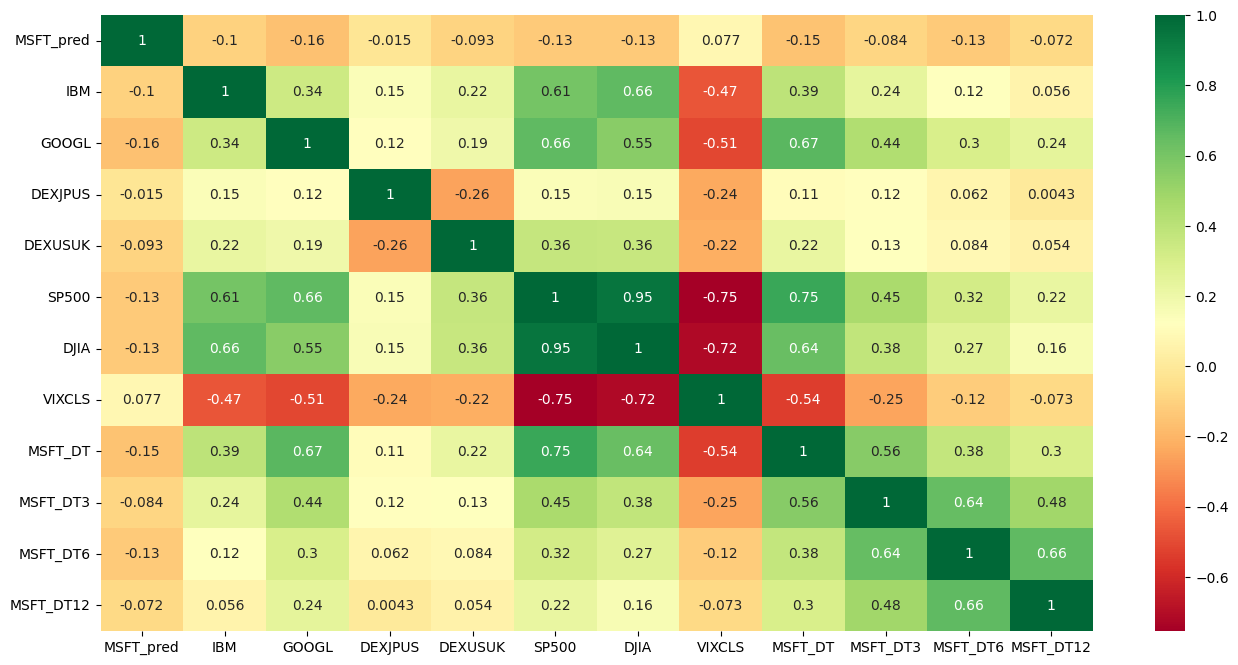

In [195]:
plt.figure(figsize=(16,8))
sns.heatmap(
    data.corr(),
    cmap='RdYlGn',
    annot=True
)
plt.show()

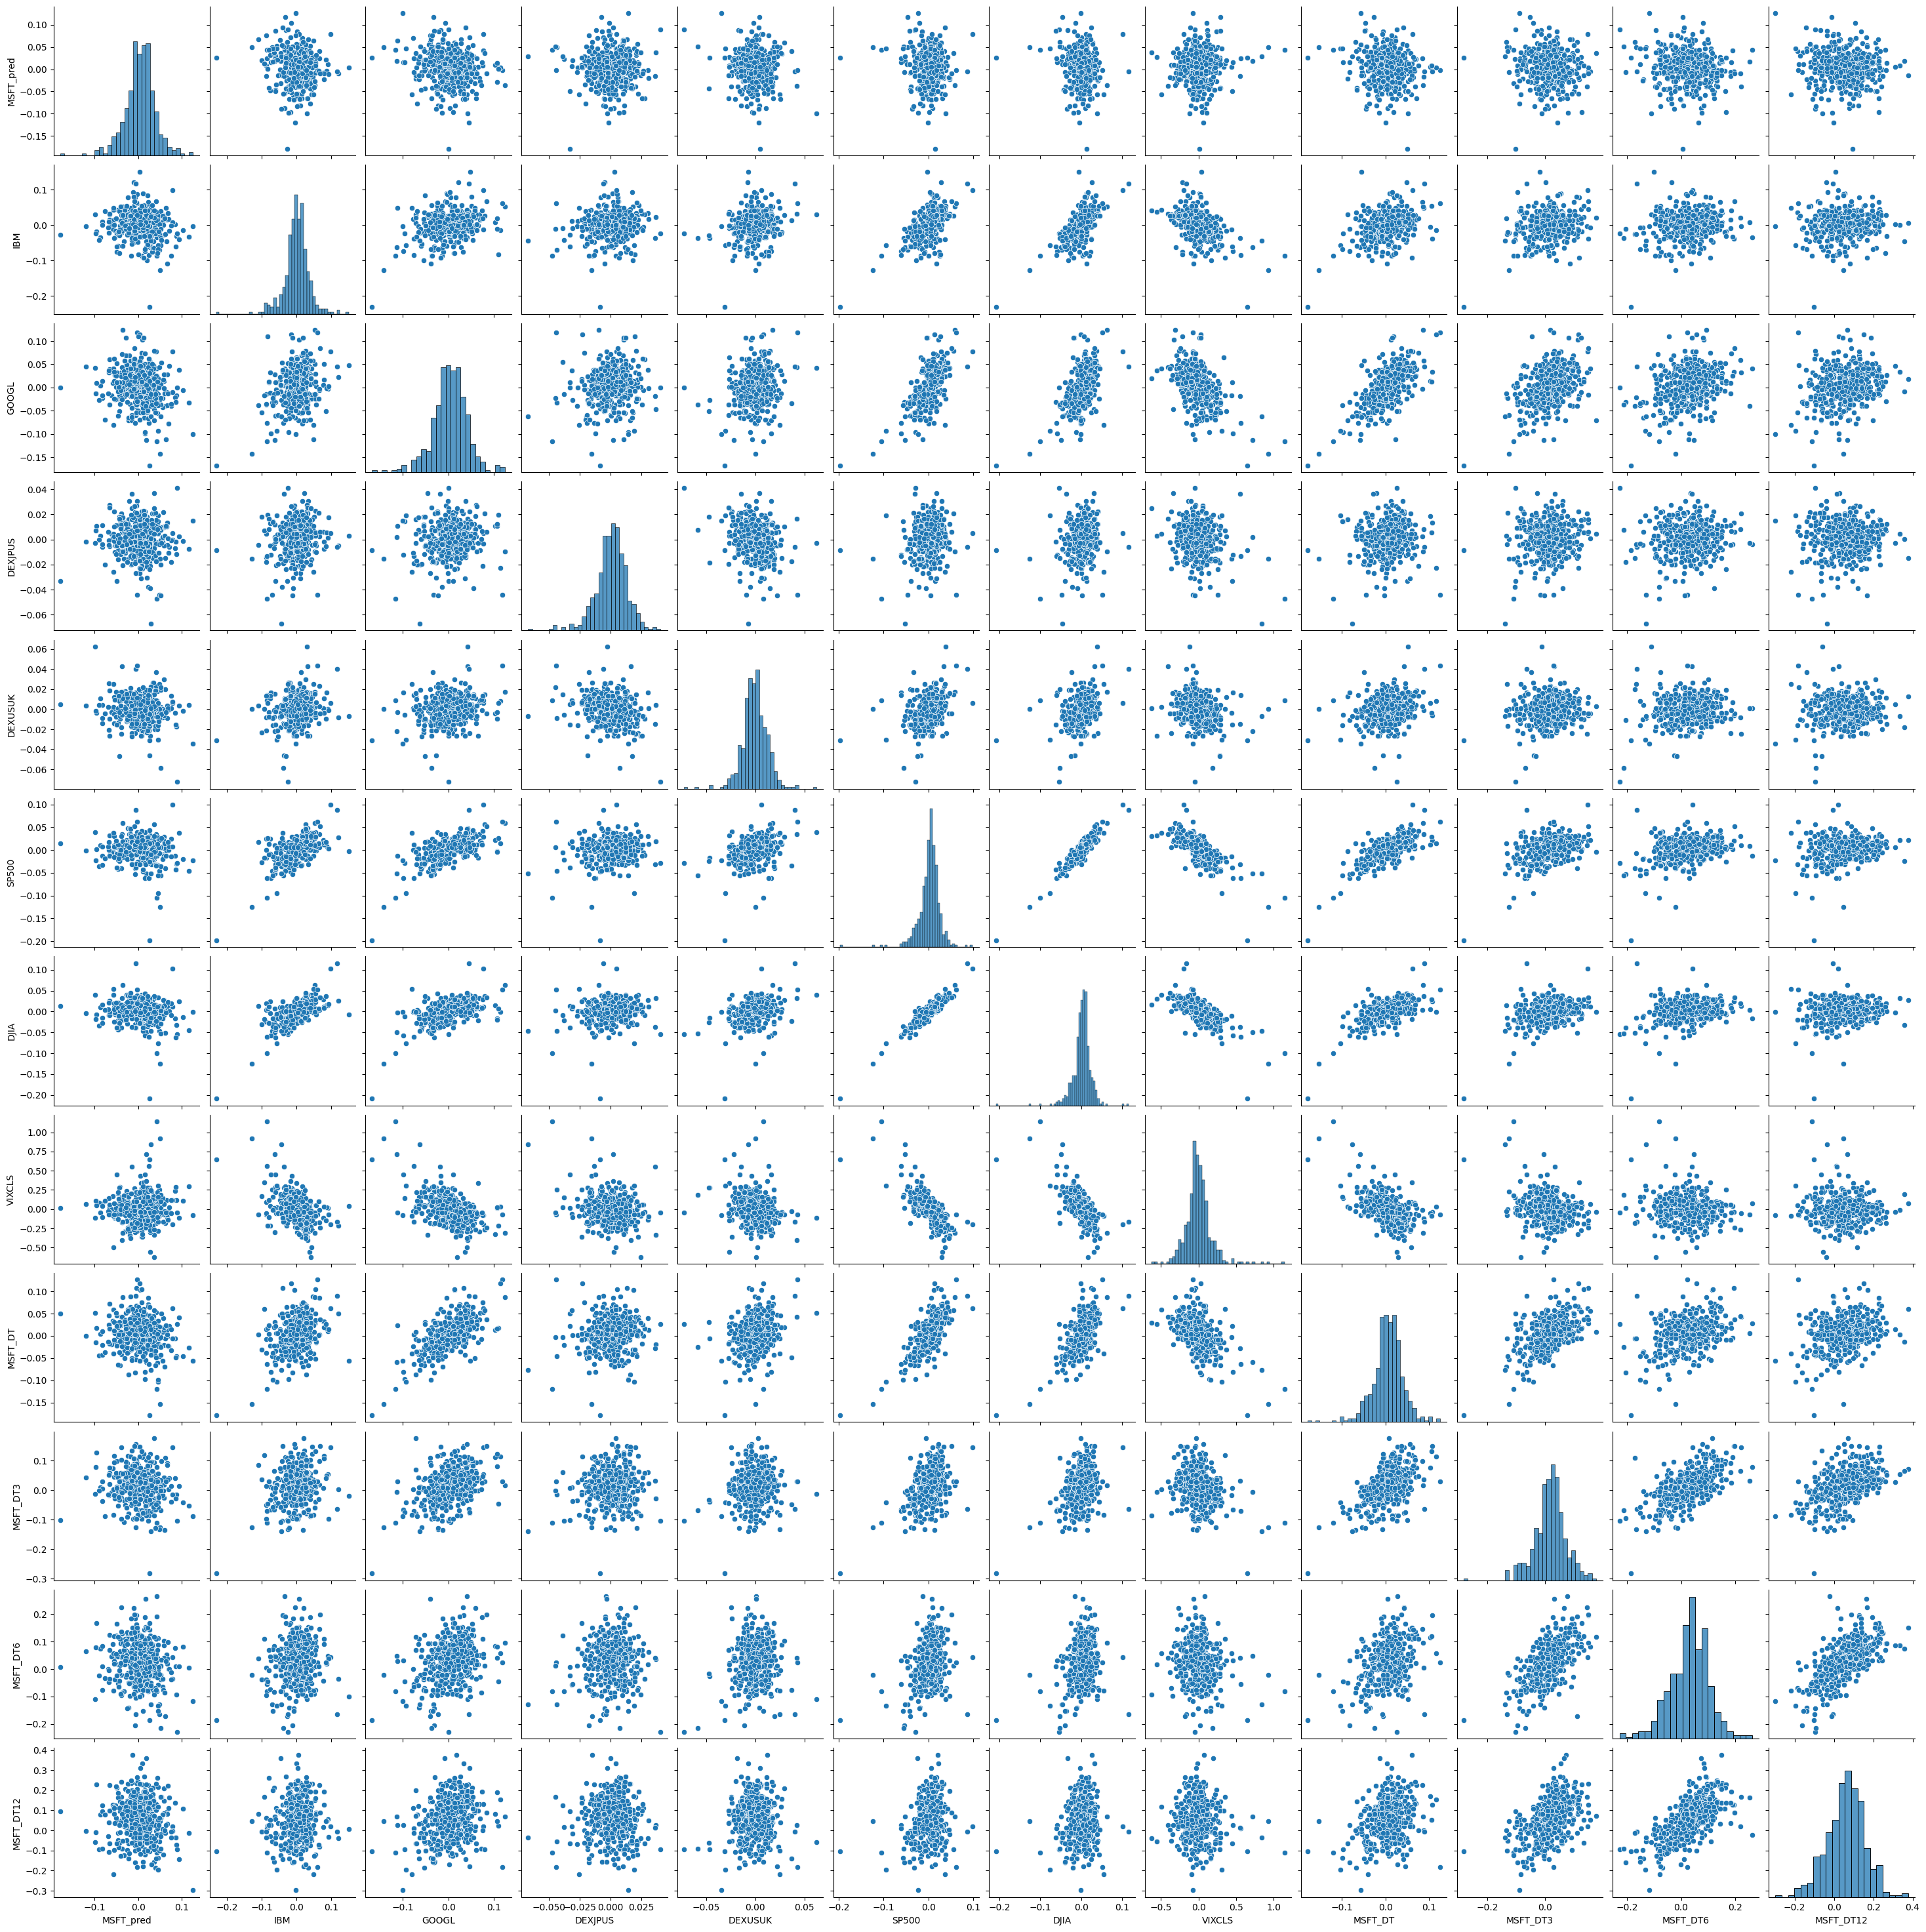

In [196]:
sns.pairplot(data)

In [197]:
res = sm.tsa.seasonal_decompose(Y, period=52)

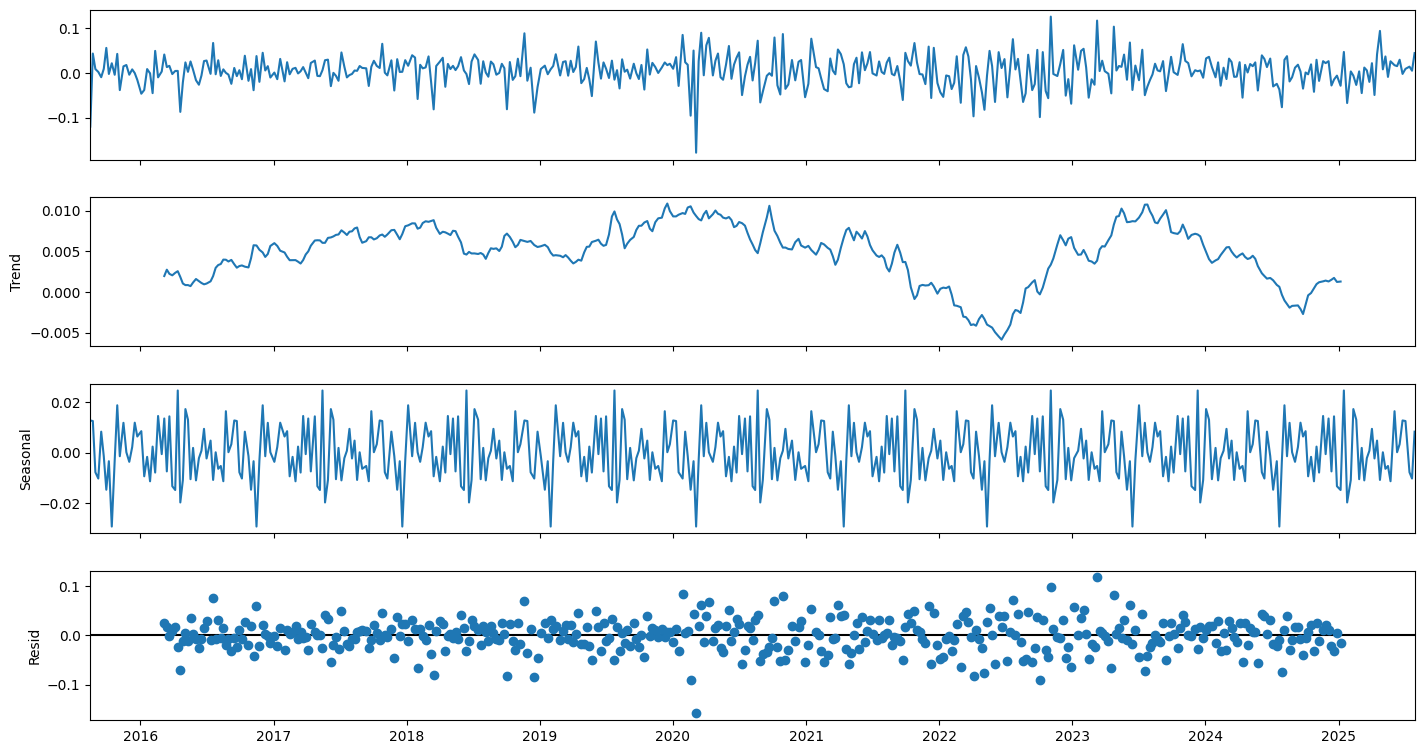

In [198]:
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [199]:
validation_size = .2

train_size = int(len(Y) * (1 - validation_size))

xtrain, xtest = X[:train_size], X[train_size:]
ytrain, ytest = Y[:train_size].values, Y[train_size:].values
ytrain, ytest = ytrain.ravel(), ytest.ravel()

In [200]:
kfolds = 10
score = 'neg_mean_squared_error'

In [201]:
models = []

models.append(('LinearRegression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('KNeighbors', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('MLP', MLPRegressor()))

In [202]:
names, kfold_scores, test_results, train_results = [], [], [], []

for name, model in models:
    names.append(name)

    kfold = KFold(n_splits=kfolds, shuffle=True, random_state=12)

    cv_results = cross_val_score(model, xtrain, ytrain, cv=kfold, scoring=score)
    kfold_scores.append(cv_results)
    
    res = model.fit(xtrain, ytrain)
    train_results.append(mean_squared_error(ytrain, res.predict(xtrain)))
    test_results.append(mean_squared_error(ytest, res.predict(xtest)))

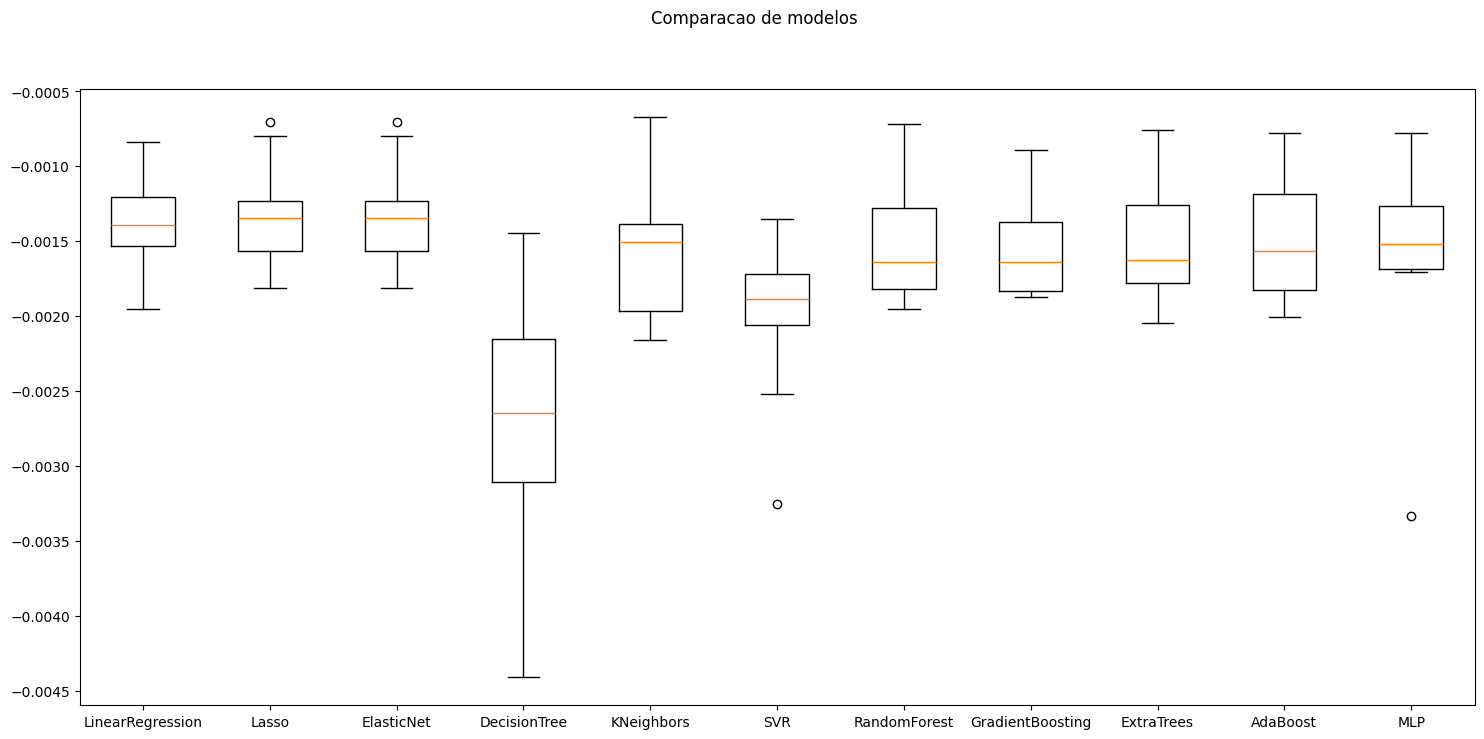

In [203]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

plt.boxplot(kfold_scores)
ax.set_xticklabels(names)
plt.show()

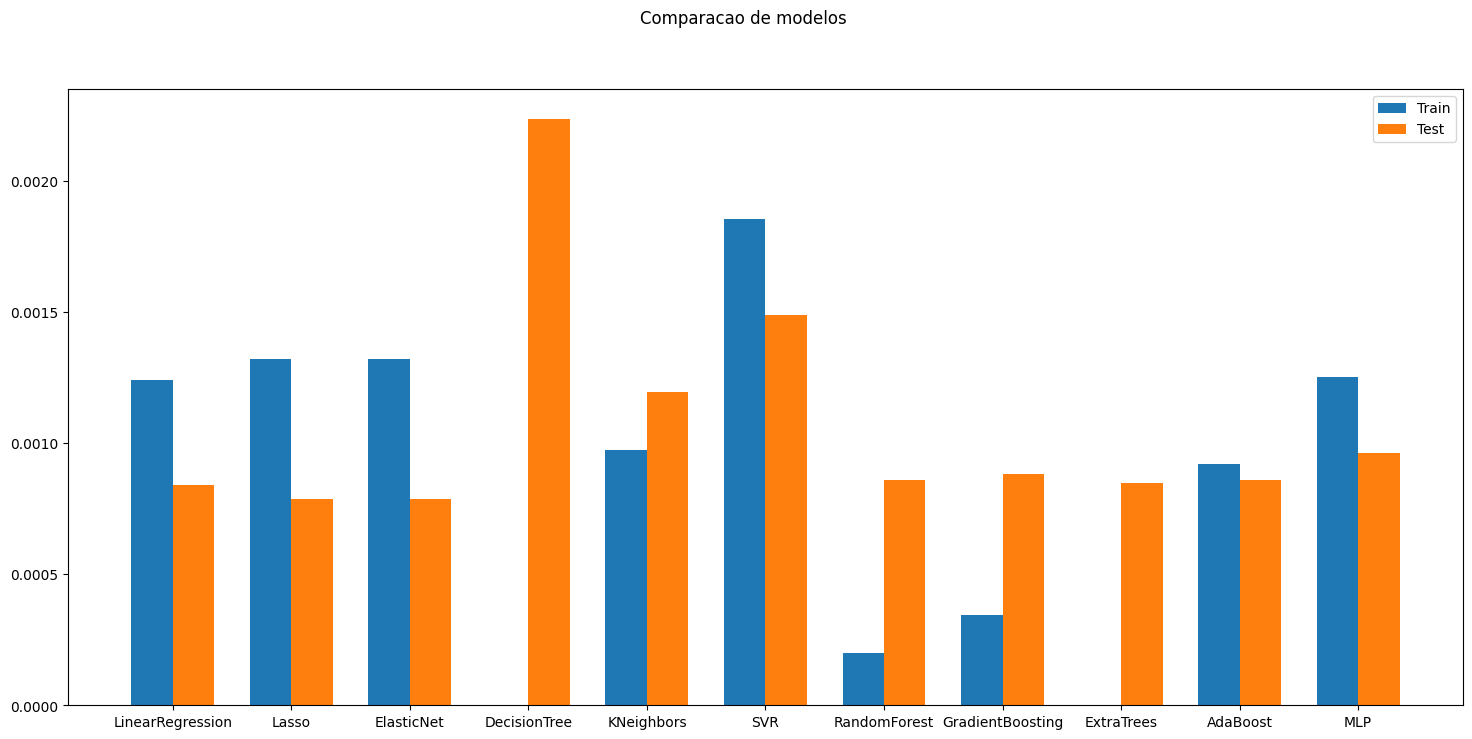

In [204]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

ind = np.arange(len(names))
width = 0.35

plt.bar(ind, train_results, width, label='Train')
plt.bar(ind + width, test_results, width, label='Test')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(names)
plt.legend()
plt.show()

Para series temporarais não necessitamos das variaveis de defasagem

In [205]:
xtrain_arima = xtrain[['IBM', 'GOOGL', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
xtest_arima  = xtest[['IBM', 'GOOGL', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]

In [206]:
tr_len = len(xtrain_arima)
te_len = len(xtest_arima)
to_len = len(X)

Treinando o modelo ARIMA

In [207]:
from statsmodels.tsa.arima.model import ARIMA

In [208]:
model_arima = ARIMA(ytrain, exog=xtrain_arima, order=(1,0,0))
mdoel_arima_fit = model_arima.fit()

In [209]:
predict = mdoel_arima_fit.predict(start=tr_len-1, end=tr_len + te_len - 1, exog=xtest_arima)[1:]

In [210]:
error_arima_train  =mean_squared_error(ytrain, mdoel_arima_fit.fittedvalues)
error_arima_train

0.0012725784885955066

In [211]:
error_arima_test = mean_squared_error(ytest, predict)
error_arima_test

0.0007690726679236118

#### LSTM

In [ ]:
def train_tsm(X, y, window=2):
    X_train, y_train = [], []
    for i in range(window, len(X)):
        X_train.append(X[i-window:i])
        y_train.append(y[i])
    return np.array(X_train), np.array(y_train)

In [213]:
X_train, y_train = train_tsm(xtrain_arima, ytrain, 2)

In [214]:
X_test, y_test = train_tsm(xtest_arima, ytest, 2)

In [215]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.01),
    loss='mean_squared_error'
)
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

In [216]:
history = model.fit(
    X_train, y_train,
    epochs=330,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0013 - val_loss: 8.1235e-04
Epoch 2/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 8.0732e-04
Epoch 3/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 8.0378e-04
Epoch 4/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - val_loss: 8.0128e-04
Epoch 5/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013 - val_loss: 7.9951e-04
Epoch 6/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 7.9826e-04
Epoch 7/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 7.9738e-04
Epoch 8/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 7.9675e-04
Epoch 9/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 7.9631e-04
Epoch 10/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 7.9599e-04
Epoch 11/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 7.9577e-04
Epoch 12/330
6/6 ━━━━━━━━━━━━━

<Axes: >

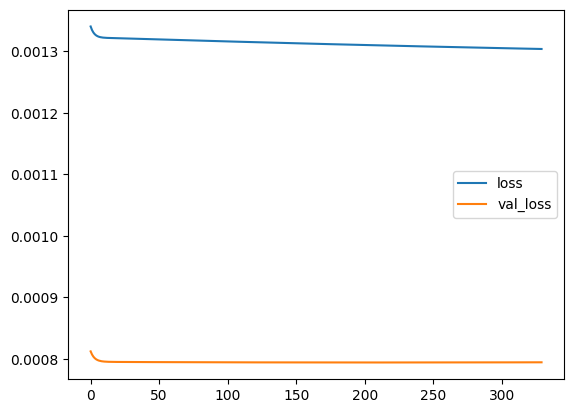

In [217]:
pd.DataFrame(history.history).plot()

In [218]:
error_train_lstm = mean_squared_error(y_train, model.predict(X_train))
error_test_lstm = mean_squared_error(y_test, model.predict(X_test))
print(f'Train error: {error_train_lstm}')
print(f'Test error: {error_test_lstm}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train error: 0.0013038050636707509
Test error: 0.0007945957819674339


#### GRU

In [219]:
model = keras.models.Sequential([
    keras.layers.GRU(80, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.GRU(80, return_sequences=True),
    keras.layers.Dropout(0.01),
    keras.layers.GRU(80),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.01),
    loss='mean_squared_error'
)

In [220]:
history = model.fit(
    X_train, y_train,
    epochs=330,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.0013 - val_loss: 8.0700e-04
Epoch 2/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 8.0038e-04
Epoch 3/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013 - val_loss: 7.9708e-04
Epoch 4/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 7.9545e-04
Epoch 5/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 7.9467e-04
Epoch 6/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_loss: 7.9431e-04
Epoch 7/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_loss: 7.9415e-04
Epoch 8/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013 - val_loss: 7.9409e-04
Epoch 9/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013 - val_loss: 7.9408e-04
Epoch 10/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 7.9408e-04
Epoch 11/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013 - val_loss: 7.9409e-04
Epoch 12/330
6/6 ━━━━━━━━━━━━

<Axes: >

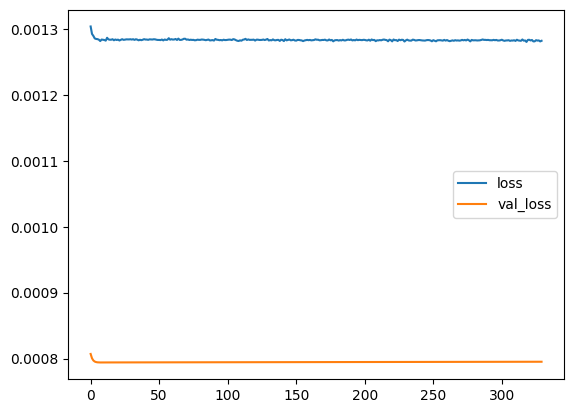

In [221]:
pd.DataFrame(history.history).plot()

In [222]:
error_train_GRU= mean_squared_error(y_train, model.predict(X_train))
error_test_GRU = mean_squared_error(y_test, model.predict(X_test))
print(f'Train error: {error_train_lstm}')
print(f'Test error: {error_test_lstm}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Train error: 0.0013038050636707509
Test error: 0.0007945957819674339


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


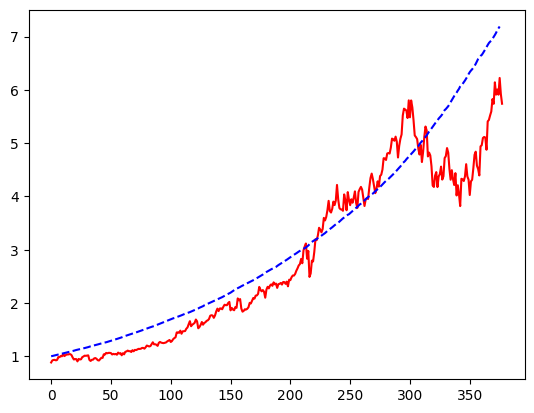

In [223]:
plt.plot(range(len(ytrain)), np.exp(ytrain).cumprod(), 'r', label='real')
plt.plot(range(len(model.predict(X_train))), np.exp(model.predict(X_train)).cumprod(), 'b--', label='predict')

#### CONV

In [224]:
X_train.shape

(376, 2, 6)

In [225]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=2, strides=2, padding='valid'),
    keras.layers.GRU(80, return_sequences=False),  # Alterei return_sequences para False
    keras.layers.Dropout(0.01),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.01),
    loss='mean_squared_error'
)

In [226]:
history = model.fit(
    X_train, y_train,
    epochs=330,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 2/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 9/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 11/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/330
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0013 - va

<Axes: >

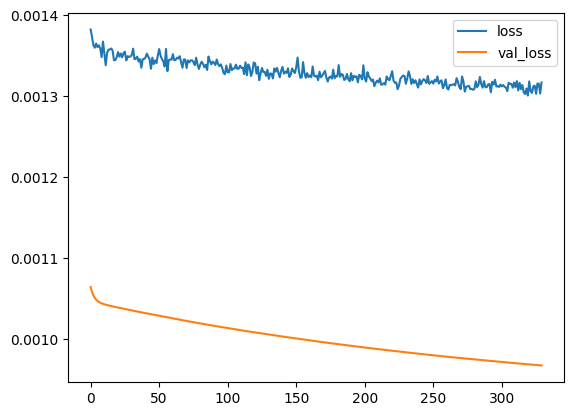

In [227]:
pd.DataFrame(history.history).plot()

In [228]:
error_train_CONV = mean_squared_error(y_train, model.predict(X_train, verbose=0))
error_test_CONV = mean_squared_error(y_test, model.predict(X_test, verbose=0))
print(f'Train error: {error_train_CONV}')
print(f'Test error: {error_test_CONV}')

Train error: 0.0013076291996563228
Test error: 0.0009675230216301893


In [229]:
X_train.shape

(376, 2, 6)

In [230]:
test_results.append(error_test_CONV)
train_results.append(error_train_CONV)

names.append('CONV')

&nbsp;

#### Adicionadno resultados

In [231]:
test_results.append(error_test_lstm)
train_results.append(error_train_lstm)

train_results.append(error_arima_train)
test_results.append(error_arima_test)

train_results.append(error_train_GRU)
test_results.append(error_test_GRU)

In [232]:
names.append('LSTM')
names.append('ARIMA')

In [233]:
names.append('GRU')

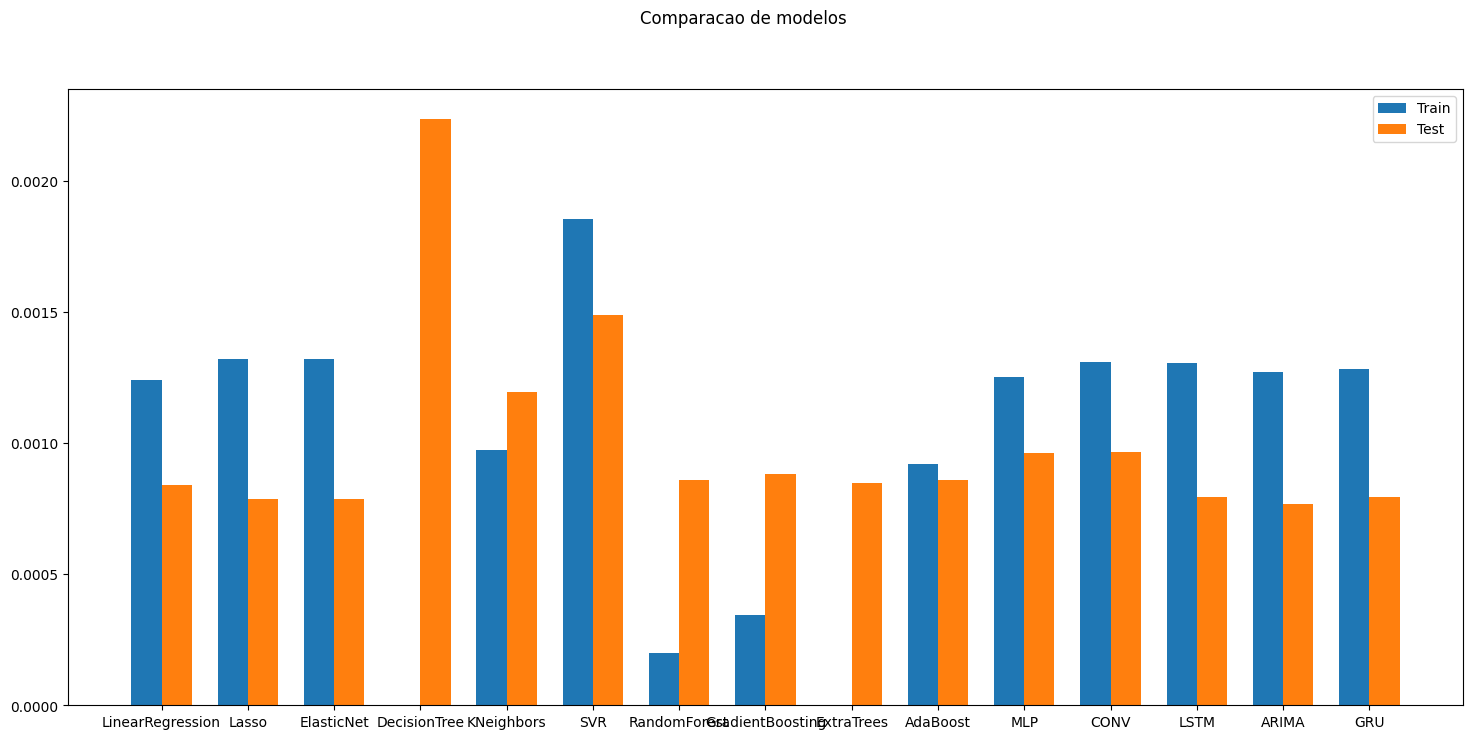

In [234]:
fig = plt.figure(figsize=(18,8))
fig.suptitle('Comparacao de modelos')
ax  = fig.add_subplot(111)

ind = np.arange(len(names))
width = 0.35

plt.bar(ind, train_results, width, label='Train')
plt.bar(ind + width, test_results, width, label='Test')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(names)
plt.legend()
plt.show()

`Encontrando os melhores hyperparametros para ARIMA`

In [235]:
def avalia_arima(arima_order):
    model_arima = ARIMA(ytrain,exog=xtrain_arima, order=arima_order)
    mdoel_arima_fit = model_arima.fit()
    error_arima_train = mean_squared_error(ytrain, mdoel_arima_fit.fittedvalues)
    return error_arima_train

In [236]:
import warnings
def search_parameters(p_values, d_values, q_values):
    best_mse = np.inf
    best_order = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    warnings.filterwarnings("ignore")
                    mse = avalia_arima(order)
                    if mse < best_mse:
                        best_mse = mse
                        best_order = order
                        print(f'New best order: {best_order} with mse: {best_mse}')
                except:
                    continue
    print(f'Best order: {best_order} with mse: {best_mse}')

In [237]:
p = [0, 1, 2, 3]
d = [0, 1, 2]
q = [0, 1, 2, 3]
search_parameters(p, d, q)

New best order: (0, 0, 0) with mse: 0.0012767906814306598
New best order: (0, 0, 1) with mse: 0.001271708076860836
New best order: (0, 0, 2) with mse: 0.001270575005380861
New best order: (0, 0, 3) with mse: 0.001269564835814178
New best order: (1, 0, 1) with mse: 0.0012640477476615845
New best order: (2, 0, 3) with mse: 0.0012609812134467034
New best order: (3, 0, 3) with mse: 0.0012595161006032493
Best order: (3, 0, 3) with mse: 0.0012595161006032493


In [238]:
model_best_arima = ARIMA(ytrain,exog=xtrain_arima, order=(3, 0, 3))
model_fit = model_best_arima.fit()

In [239]:
predict = model_fit.predict(start=tr_len-1, end=to_len-1, exog=xtest_arima)

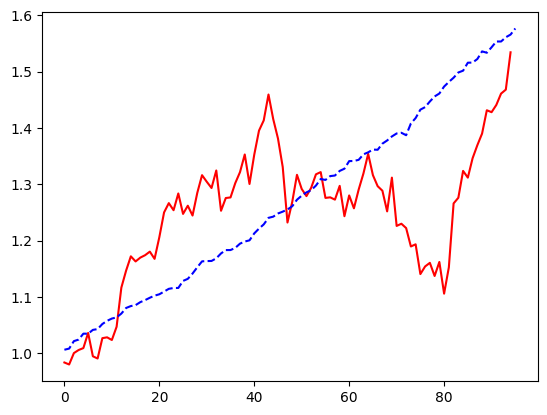

In [240]:
plt.plot(range(len(ytest)),np.exp(ytest).cumprod(), 'r', label='real')
plt.plot(range(len(predict)),np.exp(predict).cumprod(), 'b--', label='predict')
plt.show()

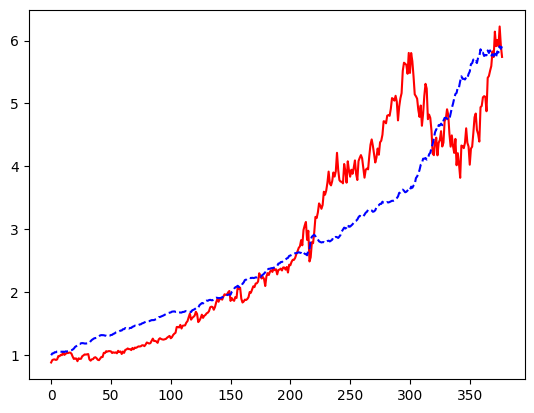

In [241]:
plt.plot(range(len(ytrain)), np.exp(ytrain).cumprod(), 'r', label='real')
plt.plot(range(len(model_fit.fittedvalues)), np.exp(model_fit.fittedvalues).cumprod(), 'b--', label='predict')
plt.show()